# 02 – Geração de Imagens Sintéticas de Videira (versão aumentada)

Este notebook tem como objetivo criar um conjunto de imagens artificiais de folhas de videira, incluindo exemplos saudáveis e com sintomas de doenças comuns (míldio, oídio, escoriose). As imagens serão usadas para treinar modelos de visão computacional na etapa seguinte.

**Abordagem:**
1. Gerar formas de folhas realistas com OpenCV (elipses distorcidas, nervuras simuladas).
2. Aplicar texturas e cores (verde saudável, amarelo/púrpura para doenças).
3. Adicionar sintomas: manchas, pústulas, bordos queimados, descoloração.
4. Gerar múltiplas variações com aumentação (rotação, escala, brilho).
5. Guardar imagens em pastas organizadas por classe e criar um ficheiro CSV com anotações.

**Nota:** Aumentámos o número de imagens por classe para 200 para melhorar o treino.

In [6]:
import cv2
import numpy as np
import os
import random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from skimage.draw import ellipse
from skimage.transform import rotate, AffineTransform, warp
from skimage import exposure

# Configurações
IMG_SIZE = 256
NUM_IMAGENS_POR_CLASSE = 200  # <-- AUMENTADO
OUTPUT_DIR = '../data/synthetic/imagens_videira/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Classes de interesse
CLASSES = ['saudavel', 'mildio', 'oidio', 'escoriose']
for cls in CLASSES:
    os.makedirs(os.path.join(OUTPUT_DIR, cls), exist_ok=True)

random.seed(42)
np.random.seed(42)

## 3. Funções auxiliares para gerar folhas

In [7]:
def gerar_folha_base(width=200, height=300):
    """Cria uma máscara de folha em forma de coração/elipse distorcida."""
    img = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Desenhar uma forma de folha (elipse + distorção)
    center = (width//2, height//2)
    axes = (width//4, height//3)
    angle = random.uniform(-20, 20)
    
    # Criar uma máscara poligonal para a folha (mais realista)
    # Vamos usar um contorno baseado em pontos de uma elipse
    t = np.linspace(0, 2*np.pi, 100)
    x = center[0] + axes[0] * np.cos(t) * (1 + 0.2*np.sin(2*t))
    y = center[1] + axes[1] * np.sin(t) * (1 + 0.2*np.cos(3*t))
    pts = np.vstack([x, y]).T.astype(np.int32)
    
    # Preencher a folha com cor verde base
    cor_base = (random.randint(30,80), random.randint(100,180), random.randint(20,60))
    cv2.fillPoly(img, [pts], cor_base)
    
    # Adicionar nervuras (linhas)
    for i in range(3):
        pt1 = (center[0] + random.randint(-10,10), center[1] - axes[1]//2)
        pt2 = (center[0] + random.randint(-20,20), center[1] + axes[1]//2)
        cv2.line(img, pt1, pt2, (0,0,0), 1)
    
    return img, pts

In [8]:
def aplicar_sintomas_mildio(img, mascara):
    """Adiciona manchas amareladas/púrpura (típicas de míldio)."""
    img2 = img.copy()
    h, w = img.shape[:2]
    
    # Gerar manchas circulares
    for _ in range(random.randint(5, 15)):
        x = random.randint(w//4, 3*w//4)
        y = random.randint(h//4, 3*h//4)
        raio = random.randint(5, 20)
        # Verificar se está dentro da máscara (folha)
        if cv2.pointPolygonTest(mascara, (float(x), float(y)), False) >= 0:
            cor_mancha = (random.randint(0,50), random.randint(100,200), random.randint(150,255))
            cv2.circle(img2, (x,y), raio, cor_mancha, -1)
    return img2

def aplicar_sintomas_oidio(img, mascara):
    """Adiciona pó branco/cinzento (oídio) em algumas áreas."""
    img2 = img.copy()
    h, w = img.shape[:2]
    
    # Criar uma máscara de pó (ruído branco)
    po_mask = np.zeros((h,w), dtype=np.uint8)
    for _ in range(random.randint(10,30)):
        x = random.randint(w//4, 3*w//4)
        y = random.randint(h//4, 3*h//4)
        if cv2.pointPolygonTest(mascara, (float(x), float(y)), False) >= 0:
            cv2.circle(po_mask, (x,y), random.randint(2,8), 255, -1)
    
    # Aplicar cor branca onde a máscara está ativa
    img2[po_mask>0] = (255,255,255)
    return img2

def aplicar_sintomas_escoriose(img, mascara):
    """Adiciona manchas escuras/necrosadas (escoriose)."""
    img2 = img.copy()
    h, w = img.shape[:2]
    
    for _ in range(random.randint(3,8)):
        x = random.randint(w//4, 3*w//4)
        y = random.randint(h//4, 3*h//4)
        if cv2.pointPolygonTest(mascara, (float(x), float(y)), False) >= 0:
            # Mancha irregular
            pts = np.array([[x-10, y-5], [x+5, y-15], [x+15, y+5], [x, y+15]], dtype=np.int32)
            cv2.fillPoly(img2, [pts], (0,0,0))
    return img2

def aumentar_imagem(img):
    """Aplica transformações de aumentação (rotação, escala, brilho)."""
    # Rotação
    angulo = random.uniform(-30, 30)
    M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angulo, 1.0)
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))
    
    # Brilho/contraste
    alpha = random.uniform(0.8, 1.2)
    beta = random.randint(-30, 30)
    img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    
    return img

## 4. Gerar dataset

In [9]:
metadata = []

for classe in CLASSES:
    print(f"Gerando {NUM_IMAGENS_POR_CLASSE} imagens para classe: {classe}")
    for i in tqdm(range(NUM_IMAGENS_POR_CLASSE)):
        # Gerar folha base
        img, pts = gerar_folha_base()
        
        # Aplicar sintomas conforme a classe
        if classe == 'mildio':
            img = aplicar_sintomas_mildio(img, pts)
        elif classe == 'oidio':
            img = aplicar_sintomas_oidio(img, pts)
        elif classe == 'escoriose':
            img = aplicar_sintomas_escoriose(img, pts)
        # saudável não tem sintomas extra
        
        # Aumentar imagem (rotação, brilho)
        img = aumentar_imagem(img)
        
        # Redimensionar para tamanho fixo
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        # Guardar imagem
        filename = f"{classe}_{i:03d}.png"
        filepath = os.path.join(OUTPUT_DIR, classe, filename)
        cv2.imwrite(filepath, img)
        
        # Adicionar aos metadados
        metadata.append({
            'filename': filename,
            'path': filepath,
            'classe': classe,
            'width': IMG_SIZE,
            'height': IMG_SIZE,
        })

# Guardar metadados em CSV
df = pd.DataFrame(metadata)
df.to_csv(os.path.join(OUTPUT_DIR, 'metadados.csv'), index=False)
print(f"\nDataset gerado: {len(df)} imagens.")
print(df['classe'].value_counts())

Gerando 200 imagens para classe: saudavel


100%|██████████| 200/200 [00:01<00:00, 195.62it/s]


Gerando 200 imagens para classe: mildio


100%|██████████| 200/200 [00:00<00:00, 206.54it/s]


Gerando 200 imagens para classe: oidio


100%|██████████| 200/200 [00:01<00:00, 196.03it/s]


Gerando 200 imagens para classe: escoriose


100%|██████████| 200/200 [00:00<00:00, 224.77it/s]


Dataset gerado: 800 imagens.
classe
saudavel     200
mildio       200
oidio        200
escoriose    200
Name: count, dtype: int64


## 5. Visualizar algumas amostras

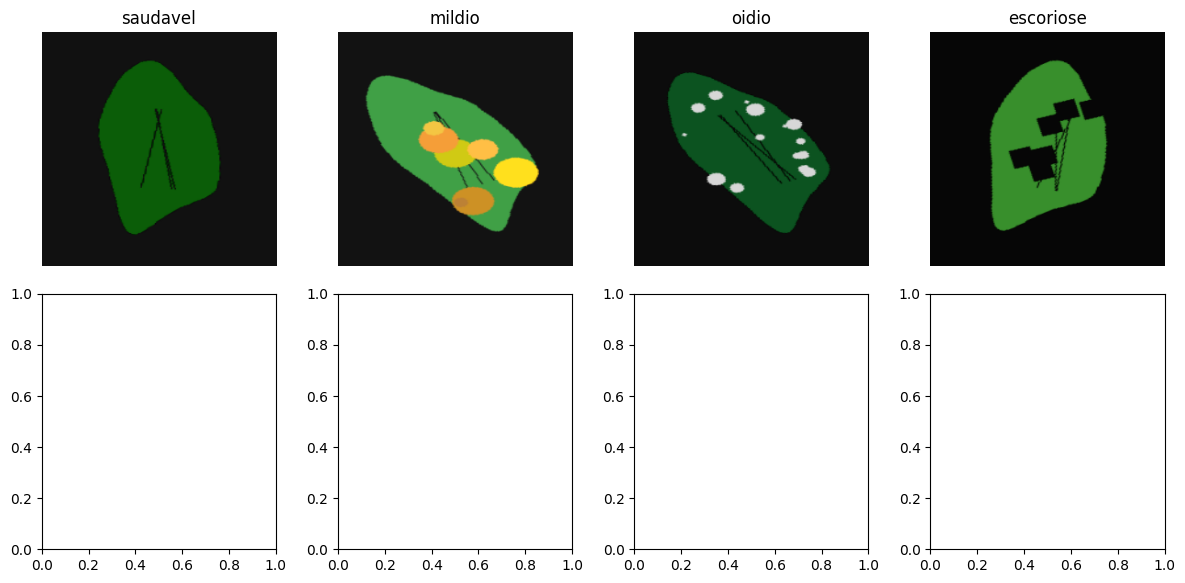

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(12,6))
axes = axes.ravel()

for idx, classe in enumerate(CLASSES):
    # Carregar uma imagem de exemplo
    exemplo = df[df['classe']==classe].iloc[0]
    img = cv2.imread(exemplo['path'])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(classe)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()